In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastestimator.dataset import div2k, flickr2k
import fastestimator as fe
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import numpy as np
from fastestimator.op.numpyop import ImageReader
from fastestimator.op import TensorOp, NumpyOp
import tensorflow as tf
from fastestimator.layers.sub_pixel_conv_2d import SubPixelConv2D
from fastestimator.schedule.lr_scheduler import LRSchedule
from fastestimator.op.tensorop import Loss, ModelOp
from fastestimator.schedule.lr_scheduler import LRSchedule
from fastestimator.trace import LRController, ModelSaver
from fastestimator.op.tensorop.augmentation import Augmentation2D, SRAugmentation2D

In [8]:
from tensorflow.keras import layers

In [9]:
train_flickr2k_csv, path_flickr2k = flickr2k.load_data('/home/ubuntu/fastestimator_data/DRLN')

df_flickr2k = pd.read_csv(train_flickr2k_csv)

train_div2k_csv, val_div2k_csv,  path_div2k = div2k.load_data('/home/ubuntu/fastestimator_data/DRLN', lr_scale=4)

path_drln = path_div2k

df_div2k  = pd.read_csv(train_div2k_csv)


df = pd.concat([df_flickr2k, df_div2k])
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
train_div2k_flickr2k_csv = os.path.join(path_drln,'div2k_flickr2k_trian.csv')
df.to_csv(train_div2k_flickr2k_csv,index=False)

In [11]:
df.head()

image_hr  \
0  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
1  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   
2  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   
3  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   
4  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   

                                            image_lr  
0  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
1  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...  
2  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...  
3  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...  
4  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...

In [7]:
# df = pd.read_csv(val_csv)

In [59]:
# df.head()

In [34]:
img_path = df['image_r'].values[0]
img = cv2.imread(img_path)
np.max(img), type(img[0][0][0])

(254, numpy.uint8)

In [73]:
len(df['image_lr'])

3450

In [83]:
height_list = []
width_list = []
length_list = []
for item in df['image_lr'].values:
    img = cv2.imread(item)
    height_list.append(img.shape[0])
    width_list.append(img.shape[1])
    length_list.append(len(img.shape))

np.max(height_list), np.max(width_list)

(510, 510)

In [85]:
np.min(height_list), np.min(width_list), np.max(length_list)

(162, 255, 3)

In [229]:
648/8, 1116/8

(81.0, 139.5)

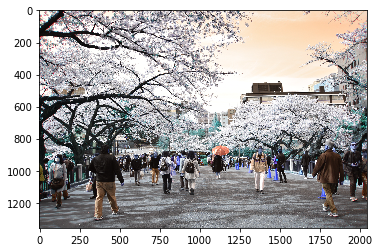

In [61]:
img = cv2.imread(df['image_hr'].values[0])
plt.imshow(img)


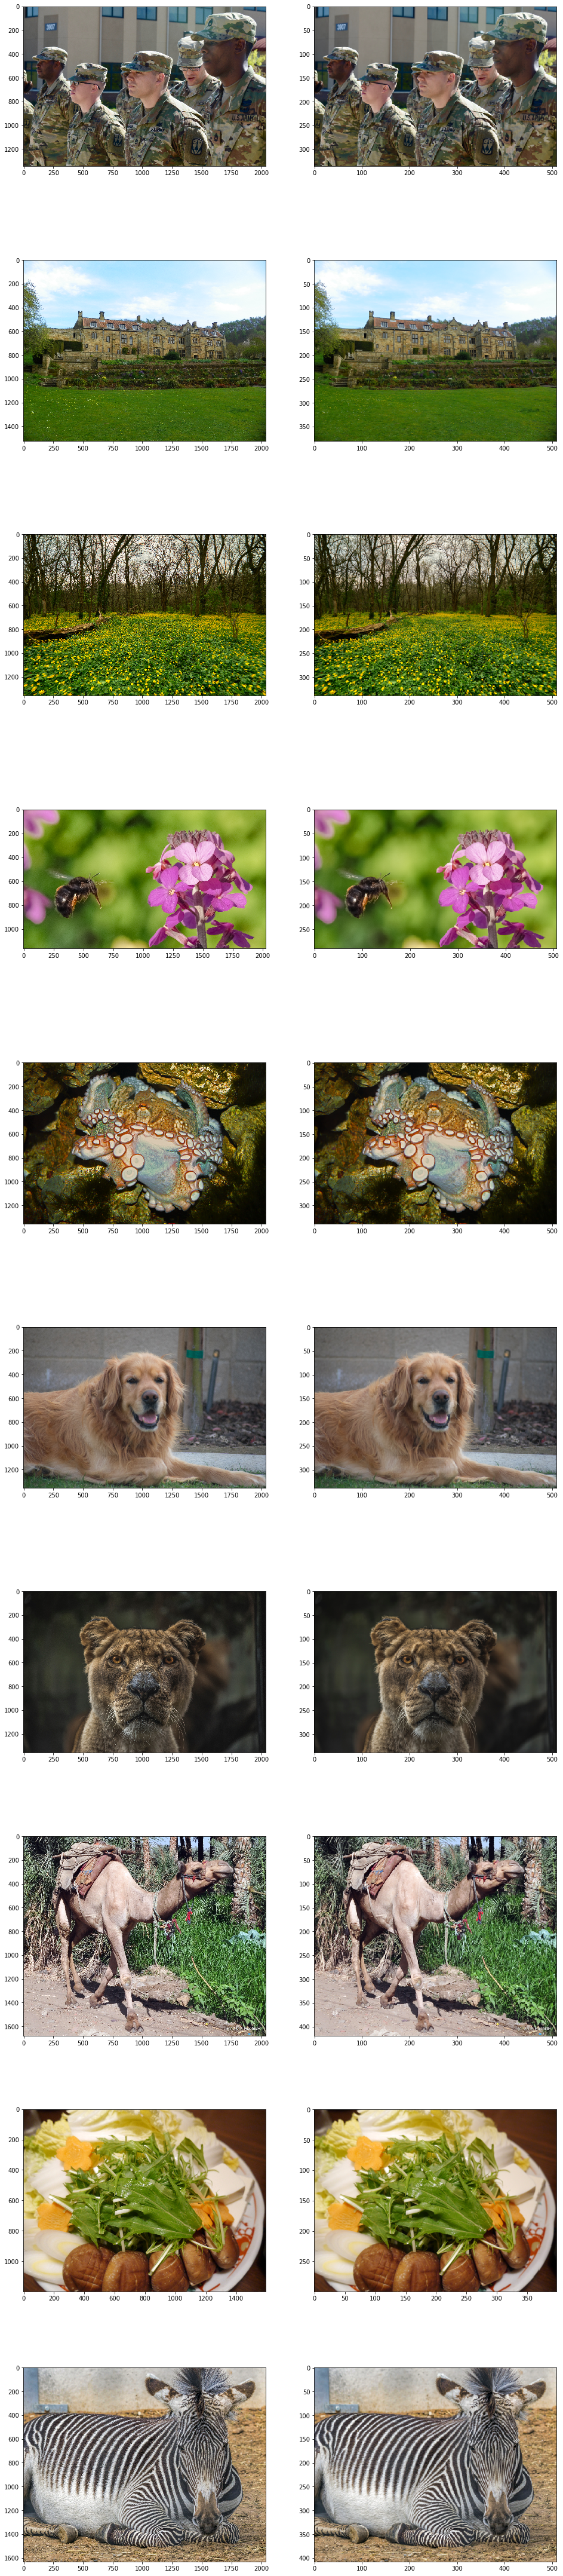

In [6]:
num_imgs_to_show = 10
start_range = 0 
end_range = start_range + num_imgs_to_show
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(16)
fig.set_figheight(80)
for idx,(img_hr_path, img_lr_path) in enumerate(zip(df['image_hr'].values[start_range:end_range],
                                                    df['image_lr'].values[start_range:end_range])):
    img_hr = cv2.imread(img_hr_path)
    img_hr =  cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    img_lr = cv2.imread(img_lr_path)
    img_lr =  cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()


In [12]:
class PadUptoTargetShape(NumpyOp):
    """Preprocessing class for padding the data

    Args:
        shape: target shape
    """
    def __init__(self, shape,inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.target_shape = shape

    def forward(self, data, state):
        """Pad data array

        Args:
            data: Data to be padded
            state: A dictionary containing background information such as 'mode'

        Returns:
            Padded array
        """
        input_shape = data.shape
        required_height_padding = self.target_shape[0] - input_shape[0]
        required_weight_padding = self.target_shape[1] - input_shape[1]
        pad_sequence = [(0, required_height_padding),(0, required_weight_padding),(0,0)]
        data_padded = np.pad(data,pad_sequence,mode='constant')
        return data_padded, input_shape

In [13]:
 writer = fe.RecordWriter(
        save_dir=os.path.join(path_div2k, "tfrecords"),
        train_data=train_div2k_flickr2k_csv,
        validation_data=val_div2k_csv,
        ops=[ImageReader(inputs="image_hr", outputs="image_hr"), 
             ImageReader(inputs="image_lr", outputs="image_lr"),
             PadUptoTargetShape((510,510),inputs='image_lr',outputs=['image_lr','lr_shape']),
             PadUptoTargetShape((2040,2040),inputs='image_hr',outputs=['image_hr','hr_shape'])
             ],
        compression="GZIP",
        write_feature=['image_hr', 'hr_shape', 'image_lr', 'lr_shape'])

In [14]:
class Rescale(TensorOp):
    """Rescaling data according to

    Args:
        inputs: Name of the key in the dataset that is to be filtered.
        outputs: Name of the key to be created/used in the dataset to store the results.
        mode: mode that the filter acts on.
    """
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        data = tf.cast(data, tf.float32)
        data /= 255
        return data

In [15]:
class RandomImagePatches(TensorOp):
    """ RandomImagePatches generates crops. These crops are defined by patch_size
    """
    def __init__(self,
                 inputs=None,
                 outputs=None,
                 mode=None,
                 lr_patch_size=(48,48), scale=4):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.lr_patch_size = lr_patch_size
        self.scale = scale

    def get_image_patch(self, image_hr, image_lr, lr_shape):
        offset_height_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                          maxval= lr_shape[0]- self.lr_patch_size[0]+1, dtype=tf.dtypes.int32)
        offset_width_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                         maxval= lr_shape[1]- self.lr_patch_size[1]+1, dtype=tf.dtypes.int32)
        crop_img_lr = image_lr[offset_height_lr[0]:offset_height_lr[0]+ self.lr_patch_size[0], 
                               offset_width_lr[0]:offset_width_lr[0]+ self.lr_patch_size[1]]
        
        offset_height_hr = offset_height_lr[0]* self.scale
        offset_width_hr =  offset_width_lr[0]* self.scale
        hr_patch_size = (self.lr_patch_size[0]*self.scale, self.lr_patch_size[1]*self.scale)
        crop_img_hr = image_hr[offset_height_hr:offset_height_hr + hr_patch_size[0], 
                               offset_width_hr:offset_width_hr + hr_patch_size[1]]
        
        return crop_img_hr, crop_img_lr

    def forward(self, data, state):
        image_hr, hr_shape, image_lr, lr_shape = data
        image_hr = image_hr[0:hr_shape[0],0:hr_shape[1],:]
        image_lr = image_lr[0:lr_shape[0],0:lr_shape[1],:]
        crop_img_hr, crop_img_lr = self.get_image_patch(image_hr,image_lr, lr_shape)
        return crop_img_hr , crop_img_lr

In [16]:
# RandomImagePatches(inputs=['image_hr','hr_shape','image_lr','lr_shape'], outputs=['image_hr','image_lr'])
pipeline = fe.Pipeline(
    batch_size=16,
    data=writer,
    ops=[  RandomImagePatches(inputs=['image_hr','hr_shape','image_lr','lr_shape'], outputs=['image_hr','image_lr']),
         SRAugmentation2D(inputs=['image_hr','image_lr'], outputs=['image_hr', 'image_lr']), 
         Rescale(inputs='image_hr', outputs='image_hr'), Rescale(inputs='image_lr',  outputs='image_lr')])


In [130]:
# pipeline = fe.Pipeline(
#     batch_size=16,
#     data=writer)


In [17]:
sample_batch= pipeline.show_results()

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/DRLN/tfrecords
FastEstimator: Found 3450 examples for train in /home/ubuntu/fastestimator_data/DRLN/tfrecords/train_summary0.json
FastEstimator: Found 100 examples for eval in /home/ubuntu/fastestimator_data/DRLN/tfrecords/eval_summary0.json


In [136]:
theta = tf.random.uniform([],maxval=5, minval=-5)
theta

<tf.Tensor: id=66019, shape=(), dtype=float32, numpy=2.8295603>

In [13]:
image_hr = sample_batch[0]['image_hr']
image_lr = sample_batch[0]['image_lr']

In [14]:
image_hr.shape, image_lr.shape

(TensorShape([16, 192, 192, 3]), TensorShape([16, 48, 48, 3]))

In [99]:
np.math.pi*5/180

0.08726646259971647

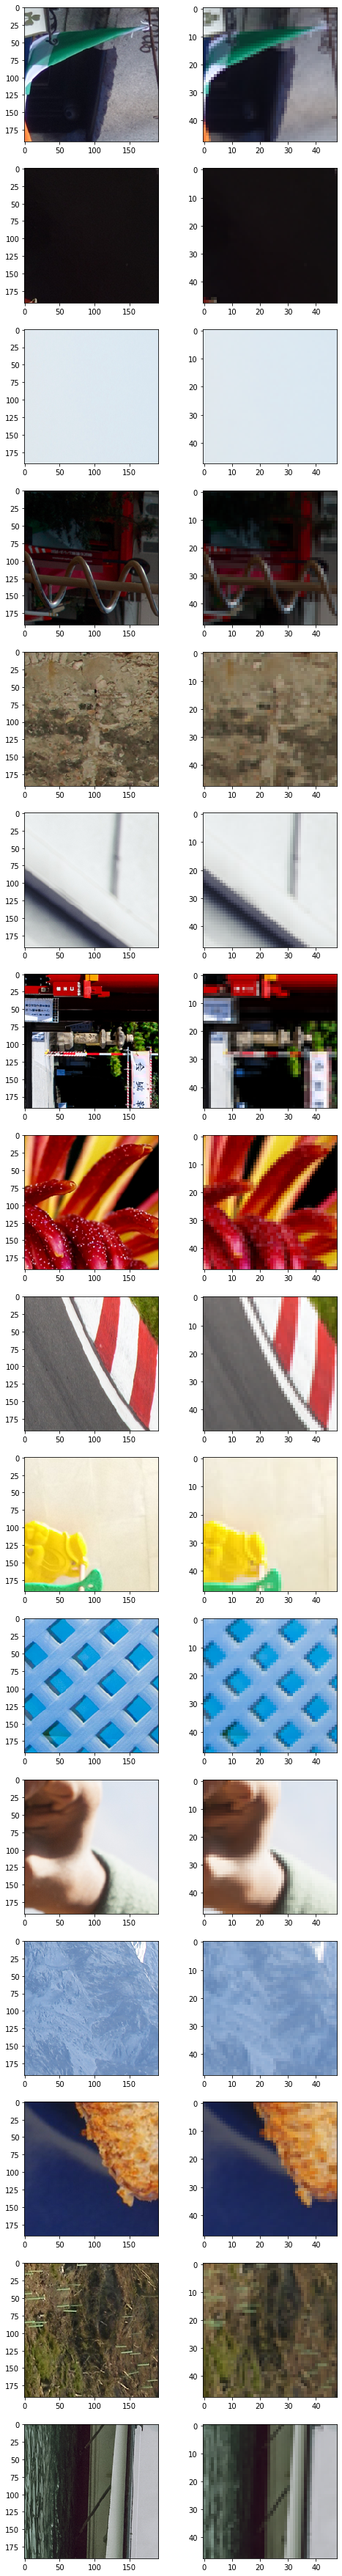

In [15]:
num_imgs_to_show = 16
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(8)
fig.set_figheight(64)
for idx,(img_hr, img_lr) in enumerate(zip(image_hr,image_lr)):
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()

In [143]:
tf.random.uniform([],maxval=1,minval=0)

<tf.Tensor: id=66168, shape=(), dtype=float32, numpy=0.68287313>

In [ ]:
# offset_height = tf.random.uniform(shape=(1, ), minval=0, 
#                                           maxval= hr_shape[0]-32+1, dtype=tf.dtypes.int32)
#         offset_width = tf.random.uniform(shape=(1, ), minval=0, 
#                                          maxval= hr_shape[1]-192+1, dtype=tf.dtypes.int32)
#         offset_height_hr = offset_height[0]
#         offset_width_hr =  offset_width[0]
#         crop_img_hr = image_hr[offset_height_hr:offset_height_hr+192, offset_width_hr:offset_width_hr+192]
#         offset_height_lr = offset_height[0]//8
#         offset_width_lr =  offset_width[0]//8
#         crop_img_lr = image_lr[offset_height_lr:offset_height_lr+32, 
#                                offset_width_lr:offset_width_lr+32]
#         return crop_img_hr, crop_img_lr

In [18]:
from tensorflow.python.keras.layers import Activation,Add,BatchNormalization,Conv2D,Input,LeakyReLU,ReLU,UpSampling3D,concatenate, Reshape
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D

In [19]:
def dcr_block(layer, filters):  # densely connected residul block
    temp = layer
    layer = Conv2D(filters,3,padding='same',activation='relu')(layer)    
    layer = Conv2D(filters,3,padding='same')(layer)
    layer = Add()([layer, temp])
    layer = Activation('relu')(layer)
    return layer

def compression(layer, filters):
    layer = Conv2D(filters, 3, padding='same', activation='relu')(layer)
    return layer
    
def laplacian_attention(layer, filters, reduction):
    temp = layer
    layer = GlobalAveragePooling2D()(layer)
    layer = Reshape(target_shape=(1,1,filters))(layer)
    kernel_initializer = tf.keras.initializers.glorot_uniform()
    filter_init = kernel_initializer(shape=(3,3,filters, filters//reduction))
    c1 = tf.nn.conv2d(layer,filters=filter_init, strides=1, padding=[[0, 0], [3,3], [3,3], [0, 0]], dilations=3)
    c2 = tf.nn.conv2d(layer, filters=filter_init, strides=1, padding=[[0, 0], [5,5], [5,5], [0, 0]], dilations=5)
    c3 = tf.nn.conv2d(layer, filters=filter_init, strides=1, padding=[[0, 0], [7,7], [7,7], [0, 0]], dilations=7)
    c_out =  concatenate([c1,c2,c3], axis=-1)
    out =  Conv2D(filters,3,padding='same',activation='sigmoid')(c_out)
    return temp * out

def upsample_block(layer, filters, scale):
    for _ in range(int(np.math.log(scale,2))):
        layer = Conv2D(filters*4,3,padding='same')(layer)
        layer = SubPixelConv2D(upsample_factor=2, nchannels=filters)(layer)
    return layer
    
def drl_module(layer, filters=64):
    
    reduction = 16

    temp = layer 
    layer = dcr_block(layer, filters)
    layer = concatenate([layer, temp], axis=-1)
    
    temp = layer 
    layer = dcr_block(layer, 2*filters)
    layer = concatenate([layer, temp], axis=-1)
    
    temp = layer 
    layer = dcr_block(layer, 4*filters)
    layer = concatenate([layer, temp], axis=-1)
    
    layer = compression(layer, filters)
    layer = laplacian_attention(layer, filters, reduction)
    return layer
    
def drl_network(input_shape=(32,32,3)):
    inputs = Input(input_shape)
    filters = 64
    
    bias_neg = tf.constant_initializer(np.array([-0.4488, -0.4371, -0.4040]))
    bias_pos = tf.constant_initializer(np.array([0.4488, 0.4371, 0.4040]))
    kernel_init = tf.constant_initializer(np.array([[[[1.,0.,0.],[0.,0.,1.],[0.,0.,1.]]]]))
    meanshifted_inputs= Conv2D(3,1, bias_initializer=bias_neg, kernel_initializer=kernel_init, trainable=False)(inputs)
    
    head = Conv2D(filters,3,padding='same')(meanshifted_inputs)
    x = head
    #===============================================================
    
    drlm_out = drl_module(head)    #1
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)

    drlm_out = drl_module(x)          # 2
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)          # 3
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a1 = head + x 
    
    #============================================================
    
    drlm_out = drl_module(a1)           # 4
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)           # 5
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)           # 6
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a2 = a1 + x
    
    #===================================================================
    
    drlm_out = drl_module(a2)           # 7
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)           # 8
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)            # 9
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a3 = a2 + x
    
    #===========================================================================
    
    drlm_out = drl_module(a3)            # 10
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)              # 11
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                # 12
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a4 = a3 + x
    
    #=================================================================
    
    drlm_out = drl_module(a4)                  # 13
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                      # 14
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                    # 15
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    
    drlm_out = drl_module(x)                       # 16
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a5 = a4 + x
    
    #=========================================================================
    
    
    
    drlm_out = drl_module(a5)                         # 17
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                          # 18
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                           # 19
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                           # 20
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a6 = a5 + x
    
    #=============================================================================
    
    out = a6 + head
    up_out = upsample_block(out, filters,scale=4)
    final_out = Conv2D(3,3,padding='same')(up_out)
    #  reverse operation of mean shift
    final_out= Conv2D(3,1, bias_initializer=bias_pos, kernel_initializer=kernel_init, trainable=False)(final_out)
    return Model(inputs=inputs, outputs=final_out)
    
    

    
    

In [20]:
class ContentLoss(Loss):
    """Compute generator loss."""
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.mae_loss =  tf.keras.losses.MeanAbsoluteError(reduction='none')

    def forward(self, data, state):
        superres, highres = data
        batch_size, _, _, _ = superres.shape
        superres = tf.reshape(superres, (batch_size, -1))
        highres = tf.reshape(highres, (batch_size, -1))
        mae_loss = self.mae_loss(highres, superres)
        return mae_loss


class MyLRSchedule(LRSchedule):
    """ lrschedule to modify lr for drln.  """
    def schedule_fn(self, current_step_or_epoch, lr):
        divisor = np.power(2,current_step_or_epoch//200000)
        lr = lr/divisor
        return lr

In [21]:
 model_drln = fe.build(model_def= lambda: drl_network(input_shape=(48,48,3)),
                          model_name="drln",
                          optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                          loss_name="mae_loss")


In [22]:
network = fe.Network(ops=[
        ModelOp(inputs='image_lr', model=model_drln, outputs='image_sr'),
        ContentLoss(inputs=("image_sr", "image_hr"), outputs=("mae_loss")),
    ])

In [23]:
model_dir = os.path.join(path_div2k)
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch=215,
    epochs=1390,
    traces=[
        ModelSaver(model_name="drln", save_dir=model_dir, save_best=True),
        LRController(model_name="drln", lr_schedule=MyLRSchedule(schedule_mode='step'))
    ])

In [3]:
215*3000, 215*16

(645000, 3440)

In [ ]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/DRLN/tfrecords
FastEstimator: Found 3450 examples for train in /home/ubuntu/fastestimator_data/DRLN/tfrecords/train_summary0.json
FastEstimator: Found 100 examples for eval in /home/ubuntu/fastestimator_data/DRLN/tfrecords/eval_summary0.json
FastEstimator-Start: step: 0; total_train_steps: 298850; drln_lr: 1e-04; 
FastEstimator-Train: step: 0; mae_loss: 0.2674244; drln_lr: 0.0001; 
FastEstimator-Train: step: 100; mae_loss: 0.1077895; examples/sec: 8.3; progress: 0.0%; drln_lr: 0.0

FastEstimator-Eval: step: 4300; epoch: 19; mae_loss: 0.0984915; min_mae_loss: 0.09817698; since_best_loss: 6; 
FastEstimator-Train: step: 4300; mae_loss: 0.1078719; examples/sec: 12.1; progress: 1.4%; drln_lr: 0.0001; 
FastEstimator-Train: step: 4400; mae_loss: 0.1085961; examples/sec: 11.3; progress: 1.5%; drln_lr: 0.0001; 
FastEstimator-Train: step: 4500; mae_loss: 0.1109499; examples/sec: 11.8; progress: 1.5%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 4515; epoch: 20; mae_loss: 0.098783; min_mae_loss: 0.09817698; since_best_loss: 7; 
FastEstimator-Train: step: 4600; mae_loss: 0.0854523; examples/sec: 11.5; progress: 1.5%; drln_lr: 0.0001; 
FastEstimator-Train: step: 4700; mae_loss: 0.095744; examples/sec: 11.8; progress: 1.6%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 4730; epoch: 21; mae_loss: 0.1056237; min_mae_loss: 0.09817698; since_best_loss: 8; 
FastEstimator-Train: step: 4800; mae_loss: 0.1060552; examples/sec: 11.5; progress: 1.6%; drln_lr: 0.0001; 
FastEstimator-Train: 

FastEstimator-Train: step: 9300; mae_loss: 0.0943485; examples/sec: 11.9; progress: 3.1%; drln_lr: 0.0001; 
FastEstimator-Train: step: 9400; mae_loss: 0.0949987; examples/sec: 11.7; progress: 3.1%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 9460; epoch: 43; mae_loss: 0.1002265; min_mae_loss: 0.09686472; since_best_loss: 1; 
FastEstimator-Train: step: 9500; mae_loss: 0.1031377; examples/sec: 11.8; progress: 3.2%; drln_lr: 0.0001; 
FastEstimator-Train: step: 9600; mae_loss: 0.1021741; examples/sec: 11.8; progress: 3.2%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 9675; epoch: 44; mae_loss: 0.1005188; min_mae_loss: 0.09686472; since_best_loss: 2; 
FastEstimator-Train: step: 9700; mae_loss: 0.0986645; examples/sec: 13.4; progress: 3.2%; drln_lr: 0.0001; 
FastEstimator-Train: step: 9800; mae_loss: 0.081726; examples/sec: 10.6; progress: 3.3%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 9890; epoch: 45; mae_loss: 0.0990176; min_mae_loss: 0.09686472; since_best_loss: 3; 
FastEstimator-Train:

FastEstimator-Train: step: 14400; mae_loss: 0.096779; examples/sec: 11.8; progress: 4.8%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 14405; epoch: 66; mae_loss: 0.1027292; min_mae_loss: 0.09646594; since_best_loss: 9; 
FastEstimator-Train: step: 14500; mae_loss: 0.0969367; examples/sec: 11.9; progress: 4.9%; drln_lr: 0.0001; 
FastEstimator-Train: step: 14600; mae_loss: 0.0953064; examples/sec: 11.8; progress: 4.9%; drln_lr: 0.0001; 
FastEstimator-ModelSaver: Saving model to /home/ubuntu/fastestimator_data/DRLN/drln_best_mae_loss.h5
FastEstimator-Eval: step: 14620; epoch: 67; mae_loss: 0.0933886; min_mae_loss: 0.093388565; since_best_loss: 0; 
FastEstimator-Train: step: 14700; mae_loss: 0.1014582; examples/sec: 11.9; progress: 4.9%; drln_lr: 0.0001; 
FastEstimator-Train: step: 14800; mae_loss: 0.0950776; examples/sec: 11.8; progress: 5.0%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 14835; epoch: 68; mae_loss: 0.0998564; min_mae_loss: 0.093388565; since_best_loss: 1; 
FastEstimator-Tra

FastEstimator-Train: step: 19400; mae_loss: 0.0893366; examples/sec: 13.0; progress: 6.5%; drln_lr: 0.0001; 
FastEstimator-Train: step: 19500; mae_loss: 0.1044219; examples/sec: 10.8; progress: 6.5%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 19565; epoch: 90; mae_loss: 0.0987536; min_mae_loss: 0.093388565; since_best_loss: 23; 
FastEstimator-Train: step: 19600; mae_loss: 0.0954775; examples/sec: 12.1; progress: 6.6%; drln_lr: 0.0001; 
FastEstimator-Train: step: 19700; mae_loss: 0.0879837; examples/sec: 11.6; progress: 6.6%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 19780; epoch: 91; mae_loss: 0.0988971; min_mae_loss: 0.093388565; since_best_loss: 24; 
FastEstimator-Train: step: 19800; mae_loss: 0.0974139; examples/sec: 12.2; progress: 6.6%; drln_lr: 0.0001; 
FastEstimator-Train: step: 19900; mae_loss: 0.0934245; examples/sec: 11.5; progress: 6.7%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 19995; epoch: 92; mae_loss: 0.0982486; min_mae_loss: 0.093388565; since_best_loss: 25; 
Fast

FastEstimator-Train: step: 24500; mae_loss: 0.0976772; examples/sec: 11.8; progress: 8.2%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 24510; epoch: 113; mae_loss: 0.0948066; min_mae_loss: 0.09329154; since_best_loss: 20; 
FastEstimator-Train: step: 24600; mae_loss: 0.1004285; examples/sec: 11.9; progress: 8.2%; drln_lr: 0.0001; 
FastEstimator-Train: step: 24700; mae_loss: 0.0927423; examples/sec: 11.8; progress: 8.3%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 24725; epoch: 114; mae_loss: 0.098926; min_mae_loss: 0.09329154; since_best_loss: 21; 
FastEstimator-Train: step: 24800; mae_loss: 0.1125186; examples/sec: 11.8; progress: 8.3%; drln_lr: 0.0001; 
FastEstimator-Train: step: 24900; mae_loss: 0.0995842; examples/sec: 11.7; progress: 8.3%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 24940; epoch: 115; mae_loss: 0.1002606; min_mae_loss: 0.09329154; since_best_loss: 22; 
FastEstimator-Train: step: 25000; mae_loss: 0.0907926; examples/sec: 12.5; progress: 8.4%; drln_lr: 0.0001; 
FastE

FastEstimator-Train: step: 29600; mae_loss: 0.1035651; examples/sec: 11.6; progress: 9.9%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 29670; epoch: 137; mae_loss: 0.1004174; min_mae_loss: 0.09329154; since_best_loss: 44; 
FastEstimator-Train: step: 29700; mae_loss: 0.0939285; examples/sec: 12.1; progress: 9.9%; drln_lr: 0.0001; 
FastEstimator-Train: step: 29800; mae_loss: 0.1089426; examples/sec: 11.6; progress: 10.0%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 29885; epoch: 138; mae_loss: 0.0981837; min_mae_loss: 0.09329154; since_best_loss: 45; 
FastEstimator-Train: step: 29900; mae_loss: 0.1058044; examples/sec: 12.1; progress: 10.0%; drln_lr: 0.0001; 
FastEstimator-Train: step: 30000; mae_loss: 0.1038018; examples/sec: 11.5; progress: 10.0%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 30100; epoch: 139; mae_loss: 0.0953696; min_mae_loss: 0.09329154; since_best_loss: 46; 
FastEstimator-Train: step: 30100; mae_loss: 0.1060852; examples/sec: 11.8; progress: 10.1%; drln_lr: 0.0001; 


FastEstimator-Eval: step: 34615; epoch: 160; mae_loss: 0.0995619; min_mae_loss: 0.09329154; since_best_loss: 67; 
FastEstimator-Train: step: 34700; mae_loss: 0.0974443; examples/sec: 12.0; progress: 11.6%; drln_lr: 0.0001; 
FastEstimator-Train: step: 34800; mae_loss: 0.1141601; examples/sec: 11.5; progress: 11.6%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 34830; epoch: 161; mae_loss: 0.1024461; min_mae_loss: 0.09329154; since_best_loss: 68; 
FastEstimator-Train: step: 34900; mae_loss: 0.0931738; examples/sec: 12.1; progress: 11.7%; drln_lr: 0.0001; 
FastEstimator-Train: step: 35000; mae_loss: 0.0939031; examples/sec: 11.6; progress: 11.7%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 35045; epoch: 162; mae_loss: 0.1011538; min_mae_loss: 0.09329154; since_best_loss: 69; 
FastEstimator-Train: step: 35100; mae_loss: 0.0897797; examples/sec: 12.1; progress: 11.7%; drln_lr: 0.0001; 
FastEstimator-Train: step: 35200; mae_loss: 0.0933321; examples/sec: 11.5; progress: 11.8%; drln_lr: 0.0001;

FastEstimator-Train: step: 39700; mae_loss: 0.1013307; examples/sec: 11.6; progress: 13.3%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 39775; epoch: 184; mae_loss: 0.1021749; min_mae_loss: 0.09329154; since_best_loss: 91; 
FastEstimator-Train: step: 39800; mae_loss: 0.1002876; examples/sec: 12.1; progress: 13.3%; drln_lr: 0.0001; 
FastEstimator-Train: step: 39900; mae_loss: 0.1022219; examples/sec: 11.5; progress: 13.4%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 39990; epoch: 185; mae_loss: 0.103053; min_mae_loss: 0.09329154; since_best_loss: 92; 
FastEstimator-Train: step: 40000; mae_loss: 0.0912178; examples/sec: 12.1; progress: 13.4%; drln_lr: 0.0001; 
FastEstimator-Train: step: 40100; mae_loss: 0.0951378; examples/sec: 12.6; progress: 13.4%; drln_lr: 0.0001; 
FastEstimator-Train: step: 40200; mae_loss: 0.0987615; examples/sec: 10.7; progress: 13.5%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 40205; epoch: 186; mae_loss: 0.0996554; min_mae_loss: 0.09329154; since_best_loss: 93; 

FastEstimator-Eval: step: 44720; epoch: 207; mae_loss: 0.0984244; min_mae_loss: 0.09329154; since_best_loss: 114; 
FastEstimator-Train: step: 44800; mae_loss: 0.106838; examples/sec: 12.1; progress: 15.0%; drln_lr: 0.0001; 
FastEstimator-Train: step: 44900; mae_loss: 0.0995313; examples/sec: 11.5; progress: 15.0%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 44935; epoch: 208; mae_loss: 0.0976337; min_mae_loss: 0.09329154; since_best_loss: 115; 
FastEstimator-Train: step: 45000; mae_loss: 0.0918824; examples/sec: 12.1; progress: 15.1%; drln_lr: 0.0001; 
FastEstimator-Train: step: 45100; mae_loss: 0.0980884; examples/sec: 11.6; progress: 15.1%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 45150; epoch: 209; mae_loss: 0.1031815; min_mae_loss: 0.09329154; since_best_loss: 116; 
FastEstimator-Train: step: 45200; mae_loss: 0.1092389; examples/sec: 12.1; progress: 15.1%; drln_lr: 0.0001; 
FastEstimator-Train: step: 45300; mae_loss: 0.0867039; examples/sec: 11.5; progress: 15.2%; drln_lr: 0.000

FastEstimator-Train: step: 49800; mae_loss: 0.1055181; examples/sec: 12.4; progress: 16.7%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 49880; epoch: 231; mae_loss: 0.0984824; min_mae_loss: 0.09329154; since_best_loss: 138; 
FastEstimator-Train: step: 49900; mae_loss: 0.0918099; examples/sec: 11.2; progress: 16.7%; drln_lr: 0.0001; 
FastEstimator-Train: step: 50000; mae_loss: 0.1046983; examples/sec: 11.7; progress: 16.7%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 50095; epoch: 232; mae_loss: 0.0996146; min_mae_loss: 0.09329154; since_best_loss: 139; 
FastEstimator-Train: step: 50100; mae_loss: 0.0846671; examples/sec: 11.8; progress: 16.8%; drln_lr: 0.0001; 
FastEstimator-Train: step: 50200; mae_loss: 0.0908307; examples/sec: 11.8; progress: 16.8%; drln_lr: 0.0001; 
FastEstimator-Train: step: 50300; mae_loss: 0.1037653; examples/sec: 11.6; progress: 16.8%; drln_lr: 0.0001; 
FastEstimator-Eval: step: 50310; epoch: 233; mae_loss: 0.0997512; min_mae_loss: 0.09329154; since_best_loss: 1